In [1]:
# Set display width, load packages, import symbols
ENV["COLUMNS"]=72
using Distributions
using Interpolations
using Knet: Knet, dir, accuracy, progress, sgd, load143, save, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout,sigm # param, param0, xavier_uniform
using Knet
using Images
using Plots
using LinearAlgebra
using IterTools: ncycle, takenth
using MLDatasets
using Base.Iterators: flatten
import CUDA # functional
using ImageTransformations
using Statistics
using Memento
using NPZ
# using Interpolations
atype=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})

KnetArray{Float32, N} where N

In [2]:
const F = Float32
params = Knet.params

logger = Memento.config!("info"; fmt="[{date} | {level} | {name}]: {msg}");

include("PlotUtility.jl")
include("ImageUtility.jl")
include("TrainUtility.jl")
include("LayerUtility.jl")
include("LossUtility.jl")

using .PlotUtility
using .ImageUtility
using .TrainUtility
using .LayerUtility
using .LossUtility

In [3]:
########################### CHANGE THIS LINE FOR DATASET PARAMETER ##############################
dataset_name = "mnist"
exp_number = 1
########################### CHANGE THIS LINE FOR RESULT FOLDER NAME #############################
notebook_name = "ImplicitGONDebug" * "_" * dataset_name * string(exp_number)

if !isdir("Results")
   mkdir("Results") 
end
if  !isdir(joinpath("Results", notebook_name))
    mkdir(joinpath("Results", notebook_name))
end

if  !isdir(joinpath("Results", notebook_name, "Saved_Models"))
    mkdir(joinpath("Results", notebook_name, "Saved_Models"))
end

if  !isdir(joinpath("Results", notebook_name, "Images"))
    mkdir(joinpath("Results", notebook_name, "Images"))
end

if  !isdir(joinpath("Results", notebook_name, "Logger"))
    mkdir(joinpath("Results", notebook_name, "Logger"))
end

push!(logger, DefaultHandler(joinpath("Results", notebook_name, "Logger", "logger.log"),DefaultFormatter("[{date} | {level} | {name}]: {msg}")));

use_saved_data = false
nc = nothing

if dataset_name == "mnist"
    nc = 1
    if use_saved_data
        xtrn = npzread("Data/MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))

    else

        xtrn,_ = MNIST.traindata()
        xtst,_ = MNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

#         xtrn = resize_MNIST(xtrn, 32/28)
#         xtst = resize_MNIST(xtst, 32/28)
        
    end
    
elseif dataset_name == "fashion"
    nc = 1
    if use_saved_data

        xtrn = npzread("Data/Fashion_MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/Fashion_MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))
        
    else
        
        xtrn,_ = FashionMNIST.traindata()
        xtst,_ = FashionMNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)

    end
    
elseif dataset_name == "cifar"
    nc = 3
    xtrn,_= CIFAR10.traindata()
    xtst,_ = CIFAR10.testdata()
    xtrn = Array{Float64, 4}(xtrn)
    xtst = Array{Float64, 4}(xtst)
#     println("No implemented yet")
end

batch_size = 64

dtrn = minibatch(xtrn, batch_size; xsize = (28*28, nc,:), xtype = atype, shuffle = true)
dtst = minibatch(xtst, batch_size; xsize = (28*28, nc,:), xtype = atype);

In [4]:
function SIREN_Layer_Weight_Init(i, o; w0 = 30, is_first = false, bias::Bool = true, return_param = false)
    if is_first
       k = 1/i 
    else
        k = sqrt(6/i)/w0
    end
    w = rand(Uniform(-k,k), o, i)
    if bias 
        k_ = sqrt(1/i)
        bias = rand(Uniform(-k_, k_), o, 1)
        if return_param
            return Param(w), Param(b)
        else
            return w, bias
        end
    end
    if return_param
       return Param(w) 
    else
        return w
    end
end

SIREN_Layer_Weight_Init (generic function with 1 method)

In [5]:
gon_shape = [34, 35, 20, 10, 5, 1]

function weights(gon_shape, w0)
    theta = []  # Empty list initialization of weights
    w,b = SIREN_Layer_Weight_Init(gon_shape[1], gon_shape[2]; is_first =true, w0 = w0)
    push!(theta, w)
    push!(theta, b)
    
    w, b = SIREN_Layer_Weight_Init(gon_shape[2], gon_shape[3]; w0 = w0)
    push!(theta, w)
    push!(theta, b)
    
    w, b = SIREN_Layer_Weight_Init(gon_shape[3], gon_shape[4]; w0 = w0)
    push!(theta, w)
    push!(theta, b)
    
    w, b = SIREN_Layer_Weight_Init(gon_shape[4], gon_shape[5]; w0 = w0)
    push!(theta, w)
    push!(theta, b)
    
    w, b = SIREN_Layer_Weight_Init(gon_shape[5], gon_shape[6]; w0 = w0)
    push!(theta, w)
    push!(theta, b)
    
    theta = map(a->convert(atype,a), theta)
    return Param.(theta)
end

weights (generic function with 1 method)

In [6]:
function get_mgrid(sidelen)
    iterator = (range(-1,stop=1,length = sidelen))
    return Array{Float64}(hcat([[i,j] for i = iterator, j = iterator]...)');
end

get_mgrid (generic function with 1 method)

In [7]:
function batched_linear(theta, x_in; atype = KnetArray{Float32})
#     """
#     multiply a weight matrix of size (O, I) with a batch of matrices 
#     of size (I, W, B) to have an output of size (O, W, B), 
#     where B is the batch size.
    
#     size(theta) = (O, I)
#     size(x_in) = (O, W, B)
#     """
    o = size(theta,1)
    w = size(x_in, 2)
    b = size(x_in, 3)
    x_in_reshaped = reshape(x_in, size(x_in,1), w*b)
    out = reshape(theta * x_in_reshaped, size(theta,1), w, b)
    return out
end

batched_linear (generic function with 1 method)

In [8]:
one_conv_weight = atype(ones(1,1,1,784))

batch_size = 64
x = first(dtrn)
mgrid = get_mgrid(28)
c = atype(permutedims(repeat(mgrid,1,1,batch_size),(3,1,2)));
num_latent = 32
z = Param(atype(zeros(batch_size, 1, num_latent)))

P(KnetArray{Float32, 3}(64,1,32))

In [9]:
function model_forw(theta, z, c; w0 = 30)
   
    z_ = copy(z)
    z_ = permutedims(reshape(z_,64,1,1,32),(4,3,2,1))
    # The following line is the same for  :  hcat([z for _ = 1:size(c,2)]...)
    # However it is more efficient while taking second order derivative of the loss.
    z_rep = permutedims(conv4(one_conv_weight, z_)[:,1,:,:], (3,2,1))
    z_in = cat(c, z_rep, dims = 3)
    z_in = (permutedims(z_in, (3,2,1)))
    z = batched_linear(theta[1], z_in) .+ theta[2]
    z = sin.(w0 .* z)
    
    z = batched_linear(theta[3], z) .+ theta[4]
    z = sin.(w0 .* z)
    
    z = batched_linear(theta[5], z) .+ theta[6]
    z = sin.(w0 .* z)
    
    z = batched_linear(theta[7], z) .+ theta[8]
    z = sin.(w0 .* z)
    
    z = batched_linear(theta[9], z) .+ theta[10]
    z = sin.(30 .* z)
    z = permutedims(z, (2,1,3))
end

function loss(theta, z, x)
    x_hat = model_forw(theta, z, c)
    L = mean((x_hat- x).^2)
end

function loss_train(theta, x)
    z = Param(atype(zeros(batch_size, 1, num_latent)))
    derivative_origin = @diff loss(theta, z, x)
    dz = grad(derivative_origin, z)
    z = -dz
    x_hat = model_forw(theta, z, c)
    L = mean((x_hat- x).^2)
    return L
end

loss_train (generic function with 1 method)

In [22]:
# define model weights
theta = weights(gon_shape, 30);
# Define Learning Rate and Number of Epochs
lr = 2*1e-4
n_epochs = 500
# Specify the optimizer for each param
for p in params(theta)
    p.opt =  Knet.Adam(lr = lr, beta1 = 0.9, beta2 = 0.999)
end

In [23]:
function plot_reconstructed_images2(im_ori, im_rec, n_instances = 10, max_instance = 64, plot_size = (900,300))
    k = rand(1:max_instance, n_instances)
    ori_plot_list = reshape(im_ori[:,:,:,k[1]], (28, 28))
    recon_plot_list = reshape(im_rec[:,:,:,k[1]], (28, 28))
    for j in k[2:end]
        ori_plot_list = hcat(ori_plot_list, reshape(im_ori[:,:,:,j], (28, 28)))
        recon_plot_list = hcat(recon_plot_list, reshape(im_rec[:,:,:,j], (28, 28)))
    end
    p1 = plot(Matrix{Gray{Float32}}(ori_plot_list), title = "Original Images", size = (20,200),font =  "Courier", xtick = false, ytick = false)
    p2 = plot(Matrix{Gray{Float32}}(recon_plot_list), title = "Reconstructed Images", font = "Courier", xtick = false, ytick = false)
    plot(p1, p2, layout = (2,1), size = (900,300))
end

plot_reconstructed_images2 (generic function with 4 methods)

┣                    ┫ [0.20%, 1/500, 00:00/00:00, 108695.65i/s] 

0.069437675
0.06398738
0.06577174
0.067403294
0.06735038
0.06499455
0.06627639
0.0663612
0.064479575
0.06493604
0.05955657
0.06428801
0.06174713
0.058864985
0.054316908
0.05582681
0.052624892
0.04927028


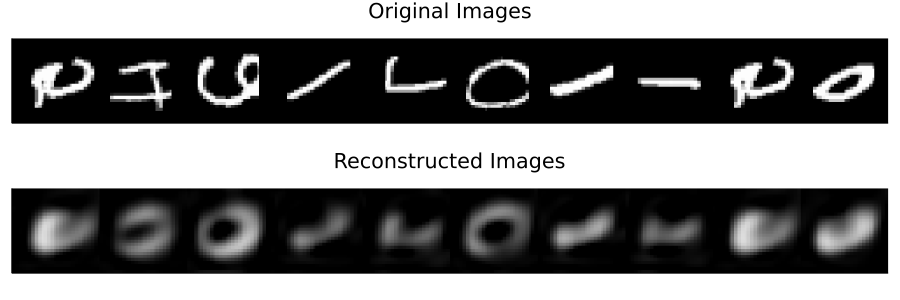

┣                    ┫ [0.40%, 2/500, 04:10/17:22:45, 250.26s/i] 

0.049842454
0.048625283
0.049437903
0.046749447
0.047010202
0.049615845
0.04847901
0.045786448
0.04434249
0.04586093
0.042960983
0.04136822
0.04431809
0.044546206
0.040319324
0.042121176
0.04109741
0.042684108


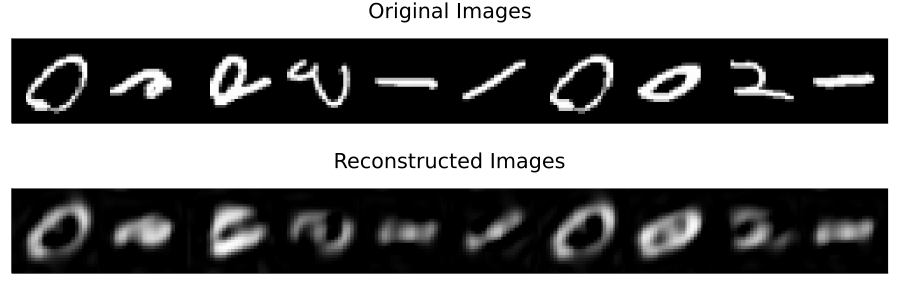

┣                    ┫ [0.60%, 3/500, 04:54/13:35:19, 43.26s/i] 

0.03814499
0.03713843
0.036371775
0.036763087
0.037475266
0.036368422
0.036168434
0.036202446
0.03803427
0.03580701
0.035438366
0.0347191
0.03539335
0.03392976
0.037012514
0.032090373
0.035677217
0.03374178


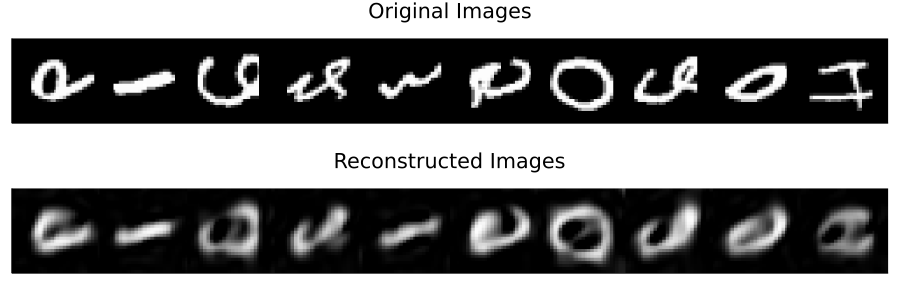

┣▏                   ┫ [0.80%, 4/500, 05:50/12:08:26, 56.14s/i] 

0.03440274
0.033002947
0.03103989
0.031956963
0.034398608
0.033425044
0.031624366
0.032222543
0.030443331
0.031536065
0.030817525
0.031492475
0.02770923
0.029668609
0.029136136
0.029567434
0.0272263
0.027057704


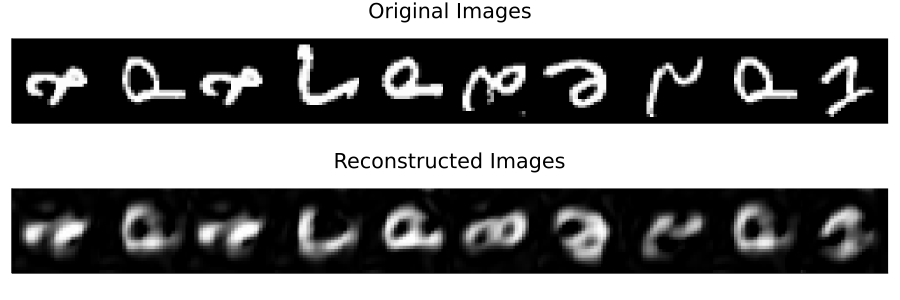

┣▏                   ┫ [1.00%, 5/500, 08:05/13:28:40, 135.55s/i] 

0.029083144
0.027366566
0.029101674
0.026121838
0.027557416
0.026649212
0.028391978
0.026312541
0.026294088
0.025026834
0.024829367
0.02644597
0.027285999
0.028976092
0.02784776
0.024495931
0.027983738
0.023591451


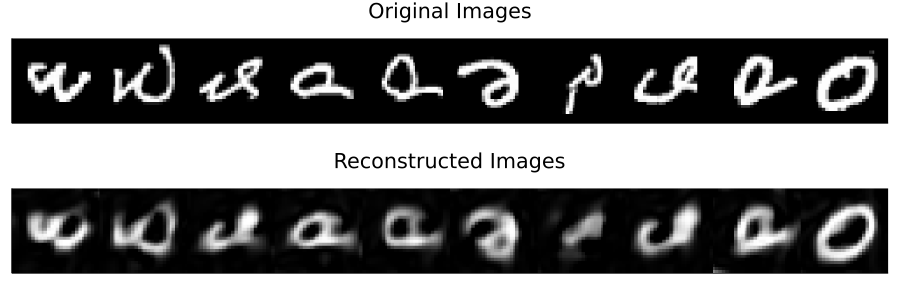

┣▏                   ┫ [1.20%, 6/500, 11:53/16:30:13, 227.76s/i] 

0.024197238


In [ ]:
x_ = first(dtrn)
for epoch in progress(1:n_epochs)
    for (i,x) in enumerate(dtrn)
        
        derivative_model = @diff loss_train(theta, x)
        
        if (i%50) == 0
           println(value(derivative_model)) 
        end
        for p in theta
            dp = grad(derivative_model, p)
            update!(value(p), dp, p.opt)
        end
    
    end
    
    z = Param(atype(zeros(batch_size, 1, num_latent)))
    derivative_origin = @diff loss(theta, z, x_)
    dz = grad(derivative_origin, z)
    z = -dz
    x_hat = model_forw(theta, z, c)
    x_hat_ = Array{Float32}(reshape(x_hat, 28,28,1,64))
    x__ = Array{Float32}(reshape(x_, 28,28,1,64))
    
    display(plot_reconstructed_images2(x__, x_hat_, 10, 64, (900,300)))
end

In [16]:
Array{Float32}(reshape(x, 28,28,1,64))

28×28×1×64 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0         …  0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0            0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0            0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0            0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0            0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0         …  0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0            0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0            0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0            0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.164706       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.909804    …  0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.643137       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.00784314     0.290196  0.0  0.0  0.0
 ⋮                        ⋮           ⋱            ⋮         
 0.0  0.0  0.0  0.0  0.0  0.0            0.14902

In [21]:
loss(theta, z, x_)

LoadError: MethodError: no method matching -(::KnetArray{Float32, 3}, ::Array{Float32, 4})
[0mClosest candidates are:
[0m  -([91m::SparseArrays.AbstractSparseMatrixCSC[39m, ::Array) at C:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.6\SparseArrays\src\sparsematrix.jl:1746
[0m  -(::KnetArray{Float32, N} where N, [91m::Knet.KnetArrays.Bcasted{var"#s3903"} where var"#s3903"<:(KnetArray{Float32, N} where N)[39m) at C:\Users\baris\.julia\packages\Knet\RCkV0\src\knetarrays\binary.jl:128
[0m  -(::KnetArray{T, N}, [91m::Knet.KnetArrays.Bcasted{var"#s3903"} where var"#s3903"<:Number[39m) where {T<:AbstractFloat, N} at C:\Users\baris\.julia\packages\Knet\RCkV0\src\knetarrays\binary.jl:299
[0m  ...

In [20]:
    z = Param(atype(zeros(batch_size, 1, num_latent)))
    derivative_origin = @diff loss(theta, z, x_)
    dz = grad(derivative_origin, z)
    z = -dz
    x_hat = model_forw(theta, z, c)
    x_hat_ = Array{Float32}(reshape(x_hat, 28,28,1,64))
    x_ = Array{Float32}(reshape(x, 28,28,1,64))
    
    display(plot_reconstructed_images2(x_, x_hat_, 10, 64, (900,300)))



Stacktrace:
  [1] forw(::Function, ::AutoGrad.Result{KnetArray{Float32, 3}}, ::Vararg{Any, N} where N; kwargs::Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ AutoGrad C:\Users\baris\.julia\packages\AutoGrad\XT5EQ\src\core.jl:66
  [2] forw
    @ C:\Users\baris\.julia\packages\AutoGrad\XT5EQ\src\core.jl:65 [inlined]
  [3] -(x1::AutoGrad.Result{KnetArray{Float32, 3}}, x2::Array{Float32, 4})
    @ AutoGrad .\none:0
  [4] loss(theta::Vector{Param{Knet.KnetArrays.KnetMatrix{Float32}}}, z::Param{KnetArray{Float32, 3}}, x::Array{Float32, 4})
    @ Main .\In[9]:29
  [5] (::var"#22#23")()
    @ Main C:\Users\baris\.julia\packages\AutoGrad\XT5EQ\src\core.jl:205
  [6] differentiate(::Function; o::Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ AutoGrad C:\Users\baris\.julia\packages\AutoGrad\XT5EQ\src\core.jl:144
  [7] differentiate(::Function)
    @ AutoGrad C:\Users\baris\.julia\packages\AutoGrad\XT5EQ\src\core.jl:140
  [8] top-le

LoadError: MethodError: no method matching -(::KnetArray{Float32, 3}, ::Array{Float32, 4})
[0mClosest candidates are:
[0m  -([91m::SparseArrays.AbstractSparseMatrixCSC[39m, ::Array) at C:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.6\SparseArrays\src\sparsematrix.jl:1746
[0m  -(::KnetArray{Float32, N} where N, [91m::Knet.KnetArrays.Bcasted{var"#s3903"} where var"#s3903"<:(KnetArray{Float32, N} where N)[39m) at C:\Users\baris\.julia\packages\Knet\RCkV0\src\knetarrays\binary.jl:128
[0m  -(::KnetArray{T, N}, [91m::Knet.KnetArrays.Bcasted{var"#s3903"} where var"#s3903"<:Number[39m) where {T<:AbstractFloat, N} at C:\Users\baris\.julia\packages\Knet\RCkV0\src\knetarrays\binary.jl:299
[0m  ...

In [12]:
x = first(dtrn)
z = Param(atype(zeros(batch_size, 1, num_latent)))
derivative_origin = @diff loss(theta, z, x)
dz = grad(derivative_origin, z)
z = -dz
x_hat = model_forw(theta, z, c)

784×1×64 KnetArray{Float32, 3}:
[:, :, 1] =
 -0.010287363
 -0.0070585394
 -0.006696029
 -0.00580248
 -0.008566237
 -0.013792427
 -0.018992104
 -0.023599891
 -0.024746103
 -0.009411075
  0.01563796
  0.020222705
  0.0059599564
  ⋮
 -0.0022903644
 -0.00064398954
  0.007981474
  0.015634965
  0.020335784
  0.017868204
  0.0072175115
  0.00059698726
  0.012601807
 -0.008551258
  0.0041690897
  0.02898511

[:, :, 2] =
  0.008492275
  0.0008569038
 -2.7527414f-5
  0.0043907966
  0.0052034673
  0.0012111982
 -0.0033569713
 -0.007795539
 -0.012177718
 -0.0041239616
  0.016231848
  0.020621106
  0.008696745
  ⋮
  0.0025077688
 -0.014823699
 -0.01132242
 -0.0010297443
  0.004419259
  0.0035871067
  0.005077635
  0.009084713
  0.007921555
  0.010274818
  0.019089647
  0.025472652

[:, :, 3] =
  0.02593841
  0.001540773
 -0.008229947
 -0.009918874
 -0.010741232
 -0.014750305
 -0.016278842
 -0.014665676
 -0.012688496
 -0.011397315
 -0.007024086
 -0.0025412876
 -0.0028543794
  ⋮
 -0.004768109
 -0.02

In [16]:
function plot_reconstructed_images2(im_ori, im_rec, n_instances = 10, max_instance = 64, plot_size = (900,300))
    k = rand(1:max_instance, n_instances)
    ori_plot_list = reshape(im_ori[:,:,:,k[1]], (28, 28))
    recon_plot_list = reshape(im_rec[:,:,:,k[1]], (28, 28))
    for j in k[2:end]
        ori_plot_list = hcat(ori_plot_list, reshape(im_ori[:,:,:,j], (28, 28)))
        recon_plot_list = hcat(recon_plot_list, reshape(im_rec[:,:,:,j], (28, 28)))
    end
    p1 = plot(Matrix{Gray{Float32}}(ori_plot_list), title = "Original Images", size = (20,200),font =  "Courier", xtick = false, ytick = false)
    p2 = plot(Matrix{Gray{Float32}}(recon_plot_list), title = "Reconstructed Images", font = "Courier", xtick = false, ytick = false)
    plot(p1, p2, layout = (2,1), size = (900,300))
end

plot_reconstructed_images2 (generic function with 4 methods)

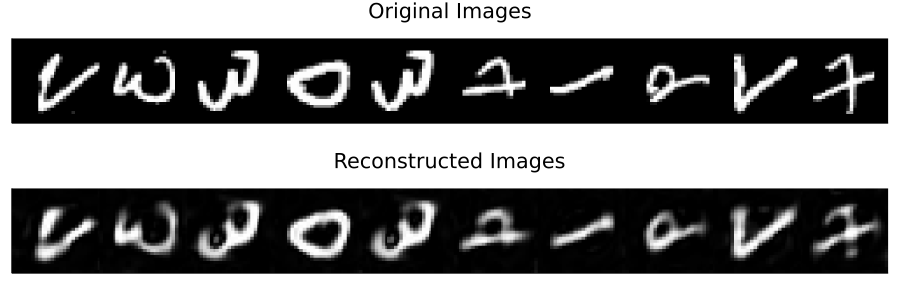

In [17]:
x_hat_ = reshape(x_hat, 28,28,1,64)
x_ = reshape(x, 28,28,1,64)
plot_reconstructed_images2(x_, x_hat_, 10, 64, (900,300))